# **Data Input**

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data1 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2013_timeseries.csv")
data2 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2014_timeseries.csv")
data3 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2015_timeseries.csv")
data4 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2016_timeseries.csv")
data5 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2017_timeseries.csv")
data6 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2018_timeseries.csv")
data7 = pd.read_csv("/content/drive/My Drive/DataThesis/Charleroi/BE_7_41871_2019_timeseries.csv")

In [3]:
ozone_charleroi = pd.concat([data1,data2,data3,data4,data5,data6,data7])

In [4]:
columns_remove = ['AirPollutant','DatetimeEnd','AirQualityStationEoICode','AirQualityStation','Countrycode','Namespace','AirQualityNetwork','SamplingProcess','SamplingPoint','Sample','AirPollutantCode','AveragingTime','UnitOfMeasurement','Validity','Verification']
ozone_charleroi = ozone_charleroi.drop(columns=columns_remove)

In [5]:
ozone_charleroi['DatetimeBegin'] = ozone_charleroi['DatetimeBegin'].str[:-7]
ozone_charleroi['DatetimeBegin'] = pd.to_datetime(ozone_charleroi['DatetimeBegin'])

In [6]:
ozone_charleroi = ozone_charleroi.sort_values(by='DatetimeBegin')
ozone_charleroi = ozone_charleroi.groupby('DatetimeBegin')['Concentration'].mean().reset_index()

In [7]:
ozone_charleroi.to_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv", index=False)

In [8]:
ozone_charleroi_ori = ozone_charleroi.copy()

In [84]:
import random

# Set the seed
random.seed(19)

In [10]:
obj = 0.20 # Percentage of observations that are going to be removed, to interpolate the removed observations and compute the MSE.

# **Linear Interpolation**

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [12]:
missing_values = int(len(ozone_charleroi) * obj)
random_indices = np.random.choice(ozone_charleroi.index, missing_values, replace=False)
ozone_charleroi.loc[random_indices, 'Concentration'] = np.nan
ozone_charleroi['Concentration'] = np.interp(ozone_charleroi.index, ozone_charleroi.dropna().index, ozone_charleroi['Concentration'].dropna())

indices_to_remove_1 = []
for index, row in ozone_charleroi_ori.iterrows():
    if pd.isna(row['Concentration']):
        indices_to_remove_1.append(index)
ozone_charleroi.drop(indices_to_remove_1, inplace=True)
ozone_charleroi_ori.drop(indices_to_remove_1, inplace=True)

In [13]:
mse_char_inter = mean_squared_error(ozone_charleroi['Concentration'],ozone_charleroi_ori['Concentration'])

In [14]:
mse_char_inter

5.904798906397743

# **ARIMA Interpolation**

In [15]:
#ozone_charleroi = pd.concat([data1,data2,data3,data4,data5,data6,data7])
#columns_remove = ['AirPollutant','DatetimeEnd','AirQualityStationEoICode','AirQualityStation','Countrycode','Namespace','AirQualityNetwork','SamplingProcess','SamplingPoint','Sample','AirPollutantCode','AveragingTime','UnitOfMeasurement','Validity','Verification']
#ozone_charleroi = ozone_charleroi.drop(columns=columns_remove)
#ozone_charleroi['DatetimeBegin'] = ozone_charleroi['DatetimeBegin'].str[:-7]
#ozone_charleroi['DatetimeBegin'] = pd.to_datetime(ozone_charleroi['DatetimeBegin'])
#ozone_charleroi = ozone_charleroi.sort_values(by='DatetimeBegin')
#ozone_charleroi = ozone_charleroi.groupby('DatetimeBegin')['Concentration'].mean().reset_index()
#ozone_charleroi.set_index('DatetimeBegin', inplace=True)
#ozone_charleroi_ori = ozone_charleroi.copy()

In [16]:
ozone_charleroi = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")
ozone_charleroi_ori = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")

In [17]:
ozone_charleroi.set_index('DatetimeBegin', inplace=True)
ozone_charleroi_ori.set_index('DatetimeBegin', inplace=True)

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

In [19]:
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

In [20]:
ozone_charleroi = ozone_charleroi.dropna(subset=['Concentration'])
ozone_charleroi_ori = ozone_charleroi_ori.dropna(subset=['Concentration'])
train_size = int(len(ozone_charleroi) * 0.8)
train, test = ozone_charleroi[:train_size], ozone_charleroi[train_size:]

In [21]:
best_model = None
best_rmse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_values = []

            # Time Series Cross-Validation
            ts_cv = TimeSeriesSplit(n_splits=2)
            for train_index, val_index in ts_cv.split(train):
                train.index = pd.to_datetime(train.index)
                train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

                if not train_fold.index.is_monotonic_increasing:
                  train_fold = train_fold.sort_index()

                # Fit ARIMA model
                model = SARIMAX(train_fold['Concentration'], order=order)
                fit_model = model.fit(disp=False)

                # Make predictions on the validation set
                predictions = fit_model.get_forecast(steps=len(val_fold))
                val_fold = val_fold.fillna(0)
                mse = mean_squared_error(val_fold, predictions.predicted_mean)
                mse_values.append(mse)

            # Calculate mean RMSE for the parameter combination
            avg_rmse = np.mean(np.sqrt(mse_values))

            # Update the best model if the current one is better
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_model = order

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [22]:
print(best_model)

(2, 1, 3)


In [23]:
obj = 0.20
missing_values = int(len(ozone_charleroi) * obj)
random_indices = np.random.choice(ozone_charleroi.index, missing_values, replace=False)
ozone_charleroi.loc[random_indices, 'Concentration'] = np.nan

In [24]:
train_data = ozone_charleroi.loc[ozone_charleroi['Concentration'].notna(), 'Concentration']
val_data = ozone_charleroi.loc[ozone_charleroi['Concentration'].isna(), 'Concentration']

if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()

model = SARIMAX(train_data, order=best_model)
fit_model = model.fit(disp=False)

predictions = fit_model.get_forecast(steps=len(val_data))
test_data = ozone_charleroi_ori.loc[random_indices, 'Concentration']
mse_ARIMA_char = mean_squared_error(test_data, predictions.predicted_mean)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

In [25]:
mse_ARIMA_char

2043.1188503769827

# **Autoencoder**

In [85]:
ozone_charleroi = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")
ozone_charleroi_ori = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_charleroi.csv")

In [86]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

In [87]:
ozone_charleroi['DatetimeBegin'] = pd.to_datetime(ozone_charleroi['DatetimeBegin'])
ozone_charleroi['date'] = ozone_charleroi['DatetimeBegin'].dt.date
ozone_charleroi['hour'] = ozone_charleroi['DatetimeBegin'].dt.hour

# Sort DataFrame by date and hour
ozone_charleroi.sort_values(by=['date', 'hour'], inplace=True)
ozone_charleroi['date'] = ozone_charleroi['date'].apply(lambda x: x.toordinal())
ozone_charleroi.drop(columns=['DatetimeBegin'], inplace=True)

In [88]:
# Preprocessing: Replace missing values with a placeholder (e.g., -1)
ozone_charleroi['Concentration'].fillna(-1, inplace=True)

# Split data into observed and missing values
ozone_charleroi = ozone_charleroi[ozone_charleroi['Concentration'] != -1]

In [89]:
missing_values = int(len(ozone_charleroi) * obj)
random_indices = np.random.choice(ozone_charleroi.index, missing_values, replace=False)
random_indices.sort()
ozone_charleroi.loc[random_indices, 'Concentration'] = -1

observed_data = ozone_charleroi[ozone_charleroi['Concentration'] != -1]
missing_data = ozone_charleroi[ozone_charleroi['Concentration'] == -1]

In [90]:
# Define the autoencoder architecture
input_dim_concentration = 1  # Concentration feature
input_dim_date = 1  # Date feature
input_dim_hour = 1  # Hour feature
encoding_dim = 4  # Adjust the size of the encoded representation as needed

input_concentration = Input(shape=(input_dim_concentration,))
input_date = Input(shape=(input_dim_date,))
input_hour = Input(shape=(input_dim_hour,))

# Concatenate inputs
concatenated = Concatenate()([input_concentration, input_date, input_hour])

# Encoder layers
encoded = Dense(32, activation='relu')(concatenated)  # First hidden layer
encoded = Dense(16, activation='relu')(encoded)      # Second hidden layer
encoded = Dense(8, activation='relu')(encoded)      # Third hidden layer
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Encoding layer

# Decoder layers
decoded = Dense(8, activation='relu')(encoded)      # First hidden layer in decoder
decoded = Dense(16, activation='relu')(decoded)      # Second hidden layer in decoder
decoded = Dense(32, activation='relu')(decoded)      # Third hidden layer in decoder
decoded = Dense(input_dim_concentration, activation='linear')(decoded)

autoencoder = Model([input_concentration, input_date, input_hour], decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder using only observed data
autoencoder.fit([observed_data['Concentration'], observed_data['date'], observed_data['hour']],
                observed_data['Concentration'],
                epochs=60, batch_size=256, shuffle=True, validation_split=0.2)

# Predict concentrations for missing dates
predicted_concentrations = autoencoder.predict([missing_data['Concentration'], missing_data['date'], missing_data['hour']])

# Fill in the missing values in the DataFrame with the predicted values
missing_data['Concentration'] = predicted_concentrations.flatten()

to_pred = ozone_charleroi_ori.loc[random_indices]
to_pred_concentration = to_pred['Concentration'].to_numpy()
mse_autoencoder = mean_squared_error(to_pred_concentration, missing_data['Concentration'])

Epoch 1/60
147/147 [==============================] - 3s 6ms/step - loss: 1089494.2500 - val_loss: 760.8973
Epoch 2/60
147/147 [==============================] - 1s 5ms/step - loss: 836.2488 - val_loss: 755.7655
Epoch 3/60
147/147 [==============================] - 1s 5ms/step - loss: 832.5439 - val_loss: 755.8840
Epoch 4/60
147/147 [==============================] - 1s 5ms/step - loss: 835.0222 - val_loss: 767.3382
Epoch 5/60
147/147 [==============================] - 1s 5ms/step - loss: 834.0963 - val_loss: 755.9482
Epoch 6/60
147/147 [==============================] - 1s 4ms/step - loss: 832.1503 - val_loss: 755.6380
Epoch 7/60
147/147 [==============================] - 0s 3ms/step - loss: 834.8651 - val_loss: 767.4498
Epoch 8/60
147/147 [==============================] - 0s 3ms/step - loss: 837.4203 - val_loss: 789.9459
Epoch 9/60
147/147 [==============================] - 0s 3ms/step - loss: 840.3467 - val_loss: 756.0212
Epoch 10/60
147/147 [==============================] - 0s 3m

<ipython-input-90-d533887b1c8d>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['Concentration'] = predicted_concentrations.flatten()


In [91]:
mse_autoencoder

803.6200935649747

# **Evaluation between Models**

In [92]:
x_values = ['Linear Interpolation','ARIMA model','Autoencoder']
y_values_lininter = [mse_char_inter,mse_ARIMA_char,mse_autoencoder]

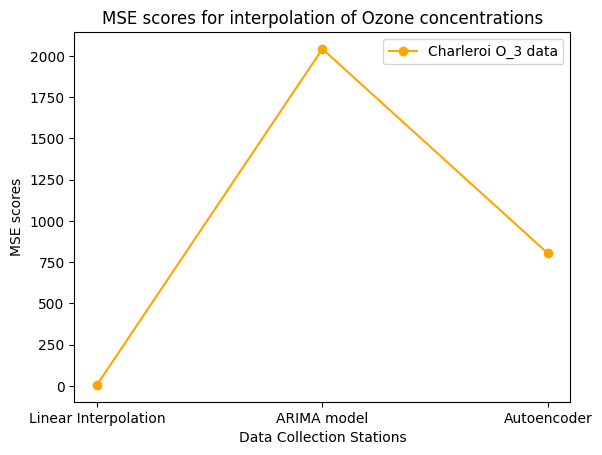

In [93]:
plt.plot(x_values, y_values_lininter, label='Charleroi O_3 data', marker='o', color='orange')
plt.xlabel('Data Collection Stations')
plt.ylabel('MSE scores')
plt.title('MSE scores for interpolation of Ozone concentrations')
plt.legend()
plt.show()